# Assignment 8 - Recognizing objects in images with deep learning

## Goals

In this assignment you will get to know the main ingredients of deep learning and get started using the GPUs available in the Big Data Lab.

You'll learn to use

 * tensors
 * automatic differentiation
 * layered learners
 * p(re)trained networks for image classification.

## Check the GPU setup

When you are logged in to a lab machine, run ``nvidia-smi`` to see the available card and its memory usage.

```
$ nvidia-smi
Mon Feb  5 08:03:15 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.12                 Driver Version: 390.12                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:01:00.0  On |                  N/A |
| 45%   24C    P8    N/A /  75W |   3087MiB /  4038MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|    0      3627      G   /usr/lib/xorg/Xorg                           169MiB |
|    0     10843      C   ...d/CMPT/big-data/tmp_py/dlenv/bin/python  2897MiB |
+-----------------------------------------------------------------------------+
```

This shows that the machine has an **NVIDIA GTX 1050 with 4G of RAM**. Also, you can see that I'm running a process (pid=10843) that currently takes up close to 3 GB of GPU memory.

```
$ pstree -ls 10843
screen───bash───jupyter-noteboo───python─┬─4*[python]
                                         └─26*[{python}]
```
Inside a terminal window you may use ``who``, ``ps -aux | less``, or ``pstree -ls <PID>`` as above to find out who is using the shared resources. In my case, it turns out that I'm running a jupyter notebook related to process 10843. Halting the notebook frees up the GPU memory. 

## PyTorch setup in the lab

In the following we are going to use **[pytorch](http://pytorch.org)**, which received some praise recently for being faster than [tensorflow](http://tensorflow.org) and for also having a nice high-level API as NN modules that are similar to [Keras](https://keras.io/).

The default `conda` environment has pytorch 1.3.1 installed. This means, you should be able to use it without any changes to your environment.
If you activate the `gt` environment, as shown at the end of [Assignment 6](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A6/A6.ipynb) you can use pytorch version 1.4 and tensorflow 2.1 (not required in this assignment).

### Use our downloaded pre-built models
To save disk space in your home folder, we recommend that you let pytorch use the pre-built models that we already downloaded for you (about 1.9G):
```
mkdir -p ~/.cache/torch/checkpoints
ln -s /usr/shared/CMPT/big-data/dot_torch_shared/checkpoints/* ~/.cache/torch/checkpoints
```

As an aside, since `~/.cache` can contain several folders (e.g. `pip` package downloads) whose size can exceed your quota, it may be a good idea to create a `dotcache` folder in your scratch space and create a symbolic link to it from `~/.cache`.

## Learn about Pytorch usage

To familiarize yourself with PyTorch, have a look at the [Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html) or briefly skim over the [60 min blitz tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

# Task 1: Finding rectangles

A nice blog-post by [Johannes Rieke](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491) presents a simple setup from scratch that finds rectangles in a black & white image. In order to play with it, we just have to translate a few calls from Keras to PyTorch.

To familiarize yourself with using pytorch, have a look at the [Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

In [10]:
# to check GPU memory, uncomment and run the following line
#!{'nvidia-smi'}

**Here is an example of the training data:**

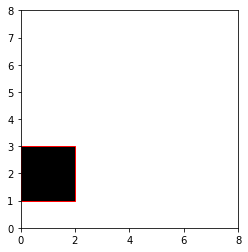

In [11]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, Markdown

%matplotlib inline

# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]
        
imgs.shape, bboxes.shape

display(Markdown('**Here is an example of the training data:**'))
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [12]:
# Reshape and normalize the image data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

## Task 1a
Construct a Pytorch model that resembles the Keras one in the original blog post, i.e. have a fully connected, hidden layer with 200 neurons, ReLU nonlinearity and dropout rate of 20%.

In [13]:
device = torch.device("cuda:0") # Uncomment this to run on GPU
model = torch.nn.Sequential(
    torch.nn.Linear(64,200),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(200, 4))
model.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=200, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=200, out_features=4, bias=True)
)

In [14]:
learning_rate = 1e-6
# optimizer = torch.optim.Adadelta(model.parameters(), learning_rate)
loss_fn = torch.nn.MSELoss(size_average=False)

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [15]:
inputs = Variable(torch.Tensor(train_X)).to(device)
labels = Variable(torch.Tensor(train_y)).to(device)

In [16]:
phase = 'train'
running_loss = 0.0
running_corrects = 0
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_record = []

for epoch in range(15000):
    optimizer.zero_grad()
    outputs = model(inputs)

    loss = loss_fn(outputs, labels)

    if phase == 'train':
        loss.backward()
        optimizer.step()

    running_loss += loss.data * inputs.size(0)
    epoch_loss = running_loss / inputs.shape[0] / (epoch+1)
    loss_record.append(epoch_loss)

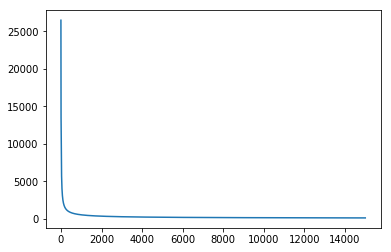

In [17]:
plt.plot(loss_record)

In [18]:
# TODO
phase = 'test'
# change the model from training to evaluation mode to improve testing performance
model.eval()

Sequential(
  (0): Linear(in_features=64, out_features=200, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=200, out_features=4, bias=True)
)

In [19]:
# Predict bounding boxes on the test images.
pred_y = model(Variable(torch.Tensor(test_X).to(device)))
pred_bboxes = pred_y.data * img_size
# data is moved to cpu 
pred_bboxes = pred_bboxes.cpu()
pred_bboxes = pred_bboxes.numpy().reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 1, 4)

In [20]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

0.9120615117289892

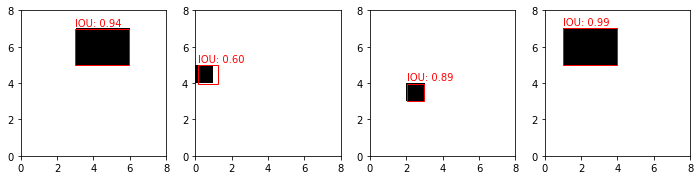

In [21]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

## Task 1b:
Move the computation that is currently done on the CPU over to the GPU using CUDA and increase the number of epochs. Improve the training setup until you **reach a test IOU above 0.9**.

You can make the changes that move computation to the GPU directly in the cells above.

You may get stuck not achieving test IOU above 0.6. In that case, learn about switching the model to evaluation mode and apply the change above.

## Question 1c:
Why does `eval` mode above have such a significant effect on test performance? Please give a short answer below.

Because batchNorm and Dropout layers have different behavior in training and evaluation(testing) modes. 
Model.eval() changes the forward() behaviour of the module it is called upon.
It disables dropout and has batch norm use the entire population statistics so that we can predict correctly.

# Task 2: Use a pretrained model

As mentioned in class, deep learning systems are hardly ever developed from scratch, but usually work by refining existing solutions to similar problems. For the following task, we'll **work through the 
[Transfer learning tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)**, which also provides a ready-made jupyter notebook.

 1. Download the notebook and get it to run in your environment. This also involves downloading the bees and ants dataset.
 2. Perform your own training with the provided setup, fill out the answer to Task 2.2 below.
 3. Change the currently chosen pretrained network (resnet) to a different one. At least try out VGG and one other type and use the "conv net as fixed feature extractor" approach, fill out the answer to Task 2.3 below.
 4. Load a picture that you took yourself and classify it with an unmodified pretrained network (e.g. the original VGG network without the modificiation that you applied in 2.3 above) so that you can detect one out of 1000 classes. Please fill out your the answer to Task 2.4 below.

# Your solution for Task 2

Before you start, get the data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and extract it into a subfolder `data`. The following import is going to attempt loading the image data from there.

Initialize much of the source code from the tutorial notebook located at
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
using [this module](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A8/tfl_tut.py)

In [22]:
from tfl_tut import *

Please study the original notebook and then continue to use its functions as imported from the `tfl_tut` model for convenience to minimize source code copy & paste.

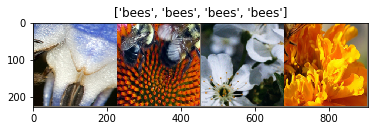

In [23]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [24]:
model_conv = torchvision.models.resnet18(pretrained=True)

### Answer for Task 2.2

In [25]:
# TODO paste and maybe modify relevant code to perform your own training
num_ftrs = model_conv.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6551 Acc: 0.6598
val Loss: 0.1929 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4667 Acc: 0.7828
val Loss: 0.3435 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.3559 Acc: 0.8689
val Loss: 0.2905 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.5422 Acc: 0.7746
val Loss: 0.3268 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.4433 Acc: 0.8443
val Loss: 0.2807 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.4295 Acc: 0.8238
val Loss: 0.3840 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.5403 Acc: 0.7992
val Loss: 0.1988 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.2967 Acc: 0.8770
val Loss: 0.1797 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.2649 Acc: 0.8893
val Loss: 0.1774 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.2692 Acc: 0.8730
val Loss: 0.1816 Acc: 0.9608

Epoch 10/24
----------
train Loss: 0.3104 Acc: 0.8566
val Loss: 0.2038 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3521 Acc: 0.8443
val Loss: 0.1857 Acc: 0.9542

Ep

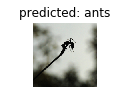

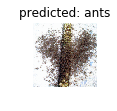

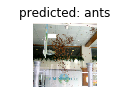

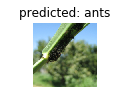

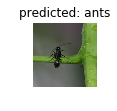

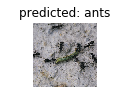

In [26]:
visualize_model(model_conv)

### Answer for Task 2.3

### Hints for this task

Focus on the section **Conv net as fixed feature xtractor** of the transfer learning tutorial.
First, change the line
```
model_conv = torchvision.models.resnet18(pretrained=True)
```
to load VGG16 instead. Set all its parameters to *not* require gradient computation, as shown in the tutorial.

Next, print out the new `model_conv` and identify the last step of the classification. This is not named the same way as the ```fc``` layer for resnet, but it works similarily. The last classification step of the VGG model determines the probabilities for each of the 1000 classes of the dataset. Change this layer to identify only 2 classes to distinguish ants and bees as in the example.

To change the structure of some `Sequential` component called ```model_conv.module_name``` and to modify its last layer into a `DifferentLayer` type, you can use this syntax:

```
nn.Sequential(*list(model_conv.module_name.children())[:-1] +
                     [nn.DifferentLayer(...)])
```
and replace the old `model_conv.module_name` with this differently structured version.

In [27]:

# don't retrain the vgg16's parameters only fine tune the last layer
model_conv = torchvision.models.vgg16(pretrained=True)
# print(model_conv)

for param in model_conv.parameters():
    param.requires_grad = False
    
# change the last layer of the classifier so that we only return two classes
model_conv.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2923 Acc: 0.8852
val Loss: 0.1000 Acc: 0.9608

Epoch 1/24
----------
train Loss: 0.2395 Acc: 0.9139
val Loss: 0.0903 Acc: 0.9673

Epoch 2/24
----------
train Loss: 0.1504 Acc: 0.9467
val Loss: 0.1132 Acc: 0.9608

Epoch 3/24
----------
train Loss: 0.1755 Acc: 0.9344
val Loss: 0.0813 Acc: 0.9673

Epoch 4/24
----------
train Loss: 0.1865 Acc: 0.9262
val Loss: 0.1265 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.1528 Acc: 0.9508
val Loss: 0.0866 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.2708 Acc: 0.9180
val Loss: 0.1024 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.1289 Acc: 0.9590
val Loss: 0.0988 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.1346 Acc: 0.9549
val Loss: 0.0960 Acc: 0.9608

Epoch 9/24
----------
train Loss: 0.1741 Acc: 0.9426
val Loss: 0.0891 Acc: 0.9608

Epoch 10/24
----------
train Loss: 0.1630 Acc: 0.9467
val Loss: 0.0885 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.1057 Acc: 0.9672
val Loss: 0.0867 Acc: 0.9608

Ep

In [ ]:
visualize_model(model_conv)

In [29]:
# don't retrain the googlenet's parameters only fine tune the last layer
model_conv = torchvision.models.googlenet(pretrained=True)
# print(model_conv)

for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features

model_conv.fc = nn.Linear(in_features=num_ftrs, out_features=2, bias=True)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# change the last layer of the classifier so that we only return two classes

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6007 Acc: 0.6803
val Loss: 0.4241 Acc: 0.8693

Epoch 1/24
----------
train Loss: 0.5849 Acc: 0.6926
val Loss: 0.5002 Acc: 0.7451

Epoch 2/24
----------
train Loss: 0.5660 Acc: 0.7090
val Loss: 0.3521 Acc: 0.8431

Epoch 3/24
----------
train Loss: 0.5313 Acc: 0.7172
val Loss: 0.2755 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.4749 Acc: 0.7869
val Loss: 0.2479 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4844 Acc: 0.7705
val Loss: 0.2559 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.3937 Acc: 0.8320
val Loss: 0.2140 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3246 Acc: 0.8770
val Loss: 0.2182 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.4427 Acc: 0.7910
val Loss: 0.2099 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3711 Acc: 0.8525
val Loss: 0.2088 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3894 Acc: 0.8238
val Loss: 0.2089 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3664 Acc: 0.8443
val Loss: 0.2333 Acc: 0.9216

Ep

In [ ]:
visualize_model(model_conv)

### Answer for Task 2.4

sports car, sport car


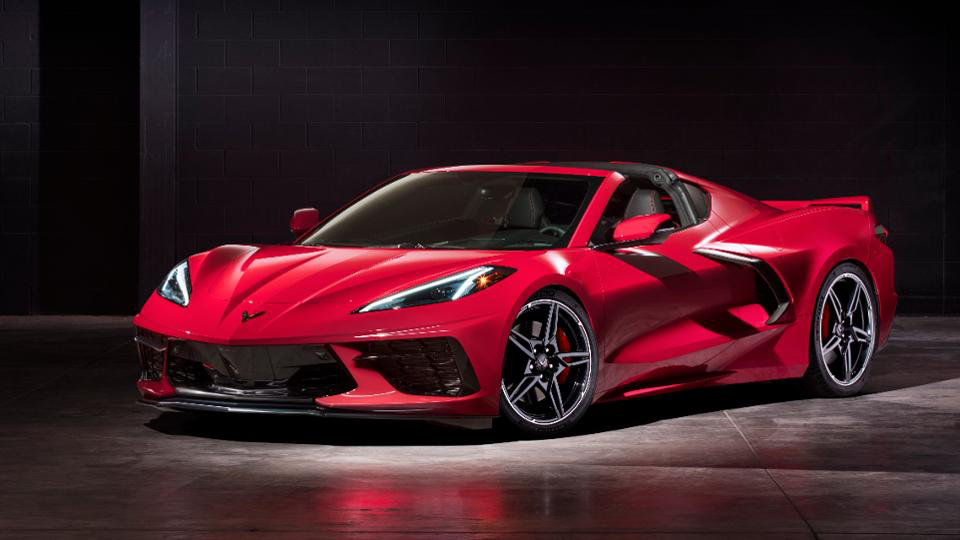

In [28]:
# I followed the tutorial on https://mlpipes.com/pytorch-quick-start-classifying-an-image/
from PIL import Image
import io
import requests

model_conv = torchvision.models.vgg16(pretrained = True)
 
# get the labels for the model 
LABELS_URL = 'https://s3.amazonaws.com/mlpipes/pytorch-quick-start/labels.json'
labels = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

# preprocess the image 
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   normalize
])

img_pil = Image.open("./image.jpg")

img_tensor = preprocess(img_pil)
img_tensor.unsqueeze_(0)# create a mini-batch as expected by the model


img_variable = Variable(img_tensor)
fc_out = model_conv(img_variable)

print(labels[fc_out.data.numpy().argmax()])
display(img_pil)

Please include the picture and its class label in the saved notebook. It's OK, if we don't have the actual image file to reproduce the output.

## Submission

Your submission should be based on a modified version of [this notebook](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A8/A8.ipynb) containing answers to Task 1 and for Task 2 including some portions of the transfer learning tutorial notebook in the sections above corresponding to tasks 2.1 - 2.4.